# Advection Diffusion Equation: Decay rate

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time
np.random.seed(1)
torch.set_default_dtype(torch.float64)

In [2]:
def u_true(x,t):
    d = x.shape[1]
    time = torch.exp(-t/d)
    return torch.sin( x.sum(dim=1) / d ) * time.squeeze()

def f(x,t):
    
    d = x.shape[1]
    time = torch.exp(-t/d)
    return torch.cos( x.sum(dim=1) / d ) * time.squeeze() / d

def g(x, t):
    return u_true(x, t)

def h(x):
    return torch.sin( x.sum(dim=1) / d )

In [3]:
class ADERF(nn.Module):
    """
    Generate random feature model
    """
    def __init__(self, in_features, out_features, sigma=1.0):
        super(ADERF, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.sigma = sigma
        self.W = nn.Parameter(torch.randn(in_features, out_features) / sigma)
        self.b = nn.Parameter(torch.rand(out_features) * 2 * torch.pi)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))

        
    def forward(self, x, t):
        
        inputs = torch.concat((x,t), dim=1)
        u = self.model(torch.cos(inputs @ self.W + self.b) * torch.sqrt( torch.tensor([2 / self.out_features])))
        return u
    
class ADE_PINN(nn.Module):
    """
    Generate PINN 
    """
    def __init__(self):
        super(ADE_PINN, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(2,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,1))
        
    def forward(self,x,t):
        
        inputs = torch.cat((x,t), dim=1)
        u = self.model(inputs)
        return u
    
def loss_fn(model, x, t, m_bd, m_int, f, g, h):
    """
    Compute the loss
    """
    
    d = x.shape[1]
    
    # interior:
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    RHS = f(x, t)
    RHS = RHS.reshape(u.shape)
    
    residual = u_t - torch.sum(u_xx, dim=1) + torch.sum(u_x, dim=1) / d - RHS
    
    # left boundary
    t_bd = torch.rand(m_bd, 1)
    x_left = - torch.ones(t_bd.shape)
    u_bd_left = model(x_left, t_bd)
    g_left = g(x_left,t_bd)
    g_left = g_left.reshape(u_bd_left.shape)
    res_left = u_bd_left - g_left
    
    # right boundary
    t_bd = torch.rand(m_bd, 1)
    x_right = torch.ones(t_bd.shape)
    u_bd_right = model(x_right, t_bd)
    g_right = g(x_right,t_bd)
    g_right = g_right.reshape(u_bd_left.shape)
    res_right = u_bd_right - g_right
    
    residual_bd = torch.concat((res_left, res_right))
        
    # initial
    x_int = 2 * torch.rand(m_int, 1) - 1
    t_int = torch.zeros(x_int.shape)
    u_int = model(x_int, t_int)
    residual_int = u_int - h(x_int).reshape(u_int.shape)
    
    return torch.mean(residual**2) + torch.Tensor([1e6])*(torch.mean(residual_int**2) + torch.mean(residual_bd**2))

def train_pinn(model, optimizer, x, t, m_bd, m_int, f, g, h, epochs=1000):
    
    losses = []
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        loss = loss_fn(model, x, t, m_bd, m_int, f, g, h)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return losses

# Rate -- number of collocation points

In [7]:
Points = [100,200,400]

# dimension
d = 1

# test at random points
m_test = 1024
x_test = 2 * torch.rand(m_test,1) - 1
t_test = torch.rand(m_test, 1)
u_test = u_true(x_test, t_test).detach().numpy()

# boundary
m_bd = 100
# initial condition
m_int = 200
# initialize model and optimizer


N = 100
epochs=[300,1000,1000]
T = 3

test_error = np.zeros((len(Points),T))

for i in range(len(Points)):
    
    m_train = Points[i]
    # generate training points
    x_train = 2 * torch.rand(m_train, d, requires_grad=True) - 1
    t_train = torch.rand(m_train, 1, requires_grad=True)
    
    for j in range(T):
    
        model_RF = ADERF(d+1, N, sigma=1)
        optimizer = optim.Adam(model_RF.parameters(), lr=1e-2, weight_decay=0.0001)

        # Train the model
        losses = train_pinn(model_RF, optimizer, x_train, t_train, m_bd, m_int, f, g, h, epochs=epochs[i])
    
        RF_pred = model_RF(x_test, t_test).detach().numpy()
        test_error[i,j] = (np.linalg.norm(RF_pred.reshape(u_test.shape) - u_test)**2 / np.size(u_test))

Epoch 0, Loss: 612866.2923041392
Epoch 0, Loss: 767862.2935516168
Epoch 0, Loss: 581739.4079821367
Epoch 0, Loss: 546460.217132904
Epoch 0, Loss: 530470.5090923845
Epoch 0, Loss: 618546.7152969476
Epoch 0, Loss: 614983.8768610292
Epoch 0, Loss: 591738.397697645
Epoch 0, Loss: 504643.3677810348


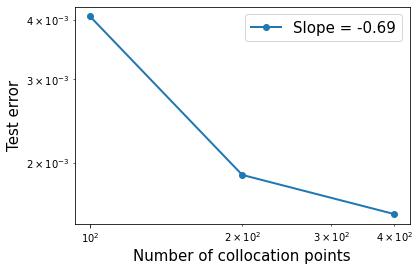

In [8]:
k = np.polyfit(np.log(Points), np.log(np.mean(test_error,axis=1)), deg=1)[0]

plt.loglog(Points, np.mean(test_error,axis=1), '-o', label=f'Slope = {k:.2f}', linewidth=2)
plt.xlabel('Number of collocation points', size=15)
plt.ylabel('Test error', size=15)
plt.legend(fontsize=15)
plt.savefig('Adv_rate_m.pdf', bbox_inches = 'tight')

# Rate -- number of random features

In [6]:
torch.manual_seed(1)
# Define parameters and synthetic data
m_train = 400

d = 1

# generate training points
x_train = 2 * torch.rand(m_train, d, requires_grad=True) - 1
t_train = torch.rand(m_train, 1, requires_grad=True)

# test at random points
m_test = 1024
x_test = 2 * torch.rand(m_test,1) - 1
t_test = torch.rand(m_test, 1)
u_test = u_true(x_test, t_test).detach().numpy()

# boundary
m_bd = 100

# initial condition
m_int = 200

# initialize model and optimizer
T = 10
N_range = [100,200,400]
test_error = np.zeros((len(N_range),T))
epochs = [50,600,600]
for i in range(len(N_range)):
    N = N_range[i]
    for j in range(T):
    
        model_RF = ADERF(d+1, N, sigma=1)
        optimizer = optim.Adam(model_RF.parameters(), lr=1e-2, weight_decay=0.0001)

        # Train the model
        losses = train_pinn(model_RF, optimizer, x_train, t_train, m_bd, m_int, f, g, h, epochs=epochs[i])
    
        RF_pred = model_RF(x_test, t_test).detach().numpy()
        test_error[i,j] = np.linalg.norm(RF_pred.reshape(u_test.shape) - u_test)**2 / np.size(u_test)

Epoch 0, Loss: 479484.58317157696
Epoch 0, Loss: 499205.94388204697
Epoch 0, Loss: 569041.8041589413
Epoch 0, Loss: 636336.6390797256
Epoch 0, Loss: 543974.1355520575
Epoch 0, Loss: 506587.7436667476
Epoch 0, Loss: 612069.522924227
Epoch 0, Loss: 566646.1961304065
Epoch 0, Loss: 492011.9890162113
Epoch 0, Loss: 632789.5036513355
Epoch 0, Loss: 648809.77404708
Epoch 0, Loss: 522925.85263309453
Epoch 0, Loss: 528812.1795911626
Epoch 0, Loss: 507365.8988283379
Epoch 0, Loss: 632880.5870870859
Epoch 0, Loss: 599155.7513787643
Epoch 0, Loss: 533712.8395306668
Epoch 0, Loss: 557568.5507904087
Epoch 0, Loss: 543218.3891028306
Epoch 0, Loss: 603404.7413331558
Epoch 0, Loss: 590594.7761395276
Epoch 0, Loss: 583360.8350703021
Epoch 0, Loss: 590281.5568453547
Epoch 0, Loss: 587985.7444885729
Epoch 0, Loss: 612200.7350221018
Epoch 0, Loss: 537514.5053096804
Epoch 0, Loss: 637337.6850063009
Epoch 0, Loss: 559770.0501270535
Epoch 0, Loss: 523839.06319183175
Epoch 0, Loss: 560546.7985862729


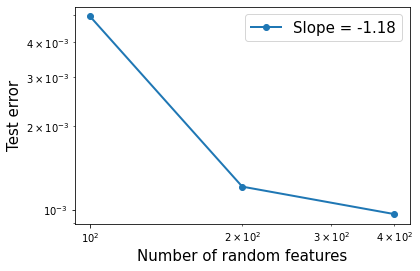

In [9]:
k_N = np.polyfit(np.log(N_range), np.log(np.mean(test_error,axis=1)), deg=1)[0]
plt.loglog(N_range, np.mean(test_error,axis=1), '-o', label=f'Slope = {k_N:.2f}', linewidth=2)
plt.xlabel('Number of random features', size=15)
plt.ylabel('Test error', size=15)
plt.legend(fontsize=15)
plt.savefig('Adv_rate_N.pdf', bbox_inches = 'tight')